# Pneumonia Detection with PyTorch & ResNet18

## Imports

In [ ]:
import os
import copy
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import ResNet18_Weights, resnet18

## Setup

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-4
PATIENCE = 5

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

## Dataset

In [4]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in ["NORMAL", "PNEUMONIA"]:
            class_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(class_dir):
                if img_name.startswith("."):
                    continue
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(0 if label == "NORMAL" else 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

### Transforms

In [5]:
train_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

eval_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
train_dataset = PneumoniaDataset(root_dir="../data/train", transform=train_transform)
test_dataset = PneumoniaDataset(root_dir="../data/test", transform=eval_transform)
val_dataset = PneumoniaDataset(root_dir="../data/val", transform=eval_transform)

### Data Exploration

In [15]:
split_datasets = {
    "Train": train_dataset,
    "Validation": val_dataset,
    "Test": test_dataset,
}
class_names = ["NORMAL", "PNEUMONIA"]

print("Dataset overview")
print(f"{'Split':<12}{'Total':>8}{'Normal':>10}{'Pneumonia':>12}{'Pneumonia %':>14}")
print("-" * 56)

split_counts = {}
for split_name, dataset in split_datasets.items():
    labels = np.array(dataset.labels)
    counts = np.bincount(labels, minlength=2)
    split_counts[split_name] = counts
    pneumonia_ratio = 100 * counts[1] / counts.sum()
    print(
        f"{split_name:<12}{counts.sum():>8}{counts[0]:>10}{counts[1]:>12}{pneumonia_ratio:>13.1f}%"
    )

Dataset overview
Split          Total    Normal   Pneumonia   Pneumonia %
--------------------------------------------------------
Train           5216      1341        3875         74.3%
Validation        16         8           8         50.0%
Test             624       234         390         62.5%


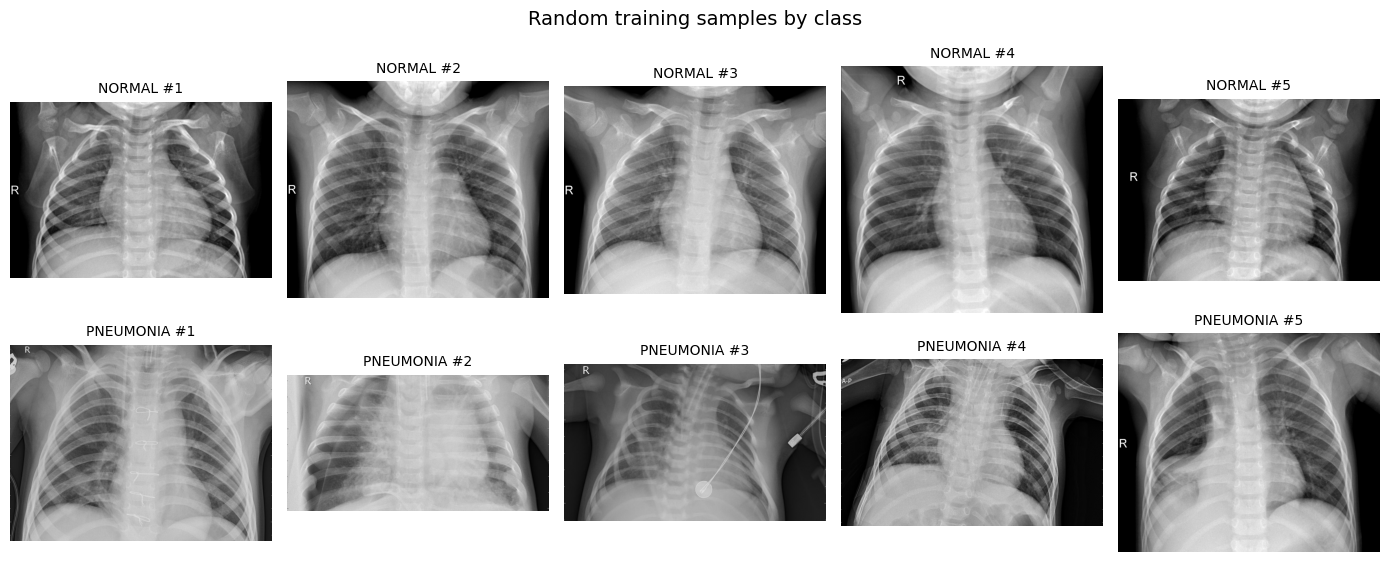

In [16]:
rng = np.random.default_rng(7)
labels_array = np.array(train_dataset.labels)

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for row, label in enumerate([0, 1]):
    indices = np.where(labels_array == label)[0]
    chosen = rng.choice(indices, size=min(5, len(indices)), replace=False)

    for col in range(5):
        ax = axes[row, col]
        ax.axis("off")

        if col >= len(chosen):
            continue

        idx = chosen[col]
        with Image.open(train_dataset.image_paths[idx]) as img:
            ax.imshow(img.convert("L"), cmap="gray")

        ax.set_title(f"{class_names[label]} #{col + 1}", fontsize=10)

fig.suptitle("Random training samples by class", fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
# Handle Class Imbalance with WeightedRandomSampler
# This dataset is heavily imbalanced (~3:1 pneumonia to normal)
train_labels = np.array(train_dataset.labels)
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(
    weights=sample_weights, num_samples=len(sample_weights), replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True
)

print(
    f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}"
)
print(
    f"Class distribution (train): Normal={class_counts[0]}, Pneumonia={class_counts[1]}"
)

Train: 5216 | Val: 16 | Test: 624
Class distribution (train): Normal=1341, Pneumonia=3875


## Model

In [ ]:
# Freeze early layers, fine-tune later ones
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer3, layer4, and fc
for name, param in model.named_parameters():
    if any(s in name for s in ["layer3", "layer4", "fc"]):
        param.requires_grad = True

model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(model.fc.in_features, 2))
model.to(device)

In [9]:
# Loss with class weights + Optimizer + Scheduler
weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=1e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)

## Training

In [10]:
best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0

for epoch in range(EPOCHS):
    # Train
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)

    # Validate
    model.eval()
    val_labels_list, val_preds_list = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_labels_list.extend(labels.cpu().numpy())
            val_preds_list.extend(predicted.cpu().numpy())

    val_acc = accuracy_score(val_labels_list, val_preds_list)
    scheduler.step(val_acc)

    print(
        f"Epoch {epoch + 1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}"
    )

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"  → New best model saved (val_acc={val_acc:.4f})")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch + 1}")
            break

Epoch 1/20: 100%|██████████| 163/163 [02:43<00:00,  1.00s/it]


Epoch 1/20 | Loss: 0.1179 | Val Acc: 1.0000 | LR: 0.000100
  → New best model saved (val_acc=1.0000)


Epoch 2/20: 100%|██████████| 163/163 [02:19<00:00,  1.17it/s]


Epoch 2/20 | Loss: 0.0747 | Val Acc: 0.8750 | LR: 0.000100


Epoch 3/20: 100%|██████████| 163/163 [02:15<00:00,  1.20it/s]


Epoch 3/20 | Loss: 0.0682 | Val Acc: 0.9375 | LR: 0.000100


Epoch 4/20: 100%|██████████| 163/163 [02:27<00:00,  1.10it/s]


Epoch 4/20 | Loss: 0.0566 | Val Acc: 1.0000 | LR: 0.000050


Epoch 5/20: 100%|██████████| 163/163 [02:29<00:00,  1.09it/s]


Epoch 5/20 | Loss: 0.0382 | Val Acc: 1.0000 | LR: 0.000050


Epoch 6/20: 100%|██████████| 163/163 [02:14<00:00,  1.21it/s]


Epoch 6/20 | Loss: 0.0366 | Val Acc: 1.0000 | LR: 0.000050
Early stopping at epoch 6


## Evaluation

In [13]:
model.load_state_dict(best_model_state)
model.eval()

class_names = ["NORMAL", "PNEUMONIA"]
test_labels_list, test_probs_list = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        test_labels_list.extend(labels.cpu().numpy())
        test_probs_list.extend(probs.cpu().numpy())

y_true = np.array(test_labels_list)
y_prob = np.array(test_probs_list)
y_pred = (y_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc_roc = roc_auc_score(y_true, y_prob)
auc_pr = average_precision_score(y_true, y_prob)
print("Test set performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"ROC-AUC:  {auc_roc:.4f}")
print(f"PR-AUC:   {auc_pr:.4f}")
print()
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

Test set performance
Accuracy: 0.9279
F1 score: 0.9413
ROC-AUC:  0.9808
PR-AUC:   0.9869

Classification report:
              precision    recall  f1-score   support

      NORMAL       0.88      0.93      0.91       234
   PNEUMONIA       0.96      0.93      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.93      0.92       624
weighted avg       0.93      0.93      0.93       624



### Plots

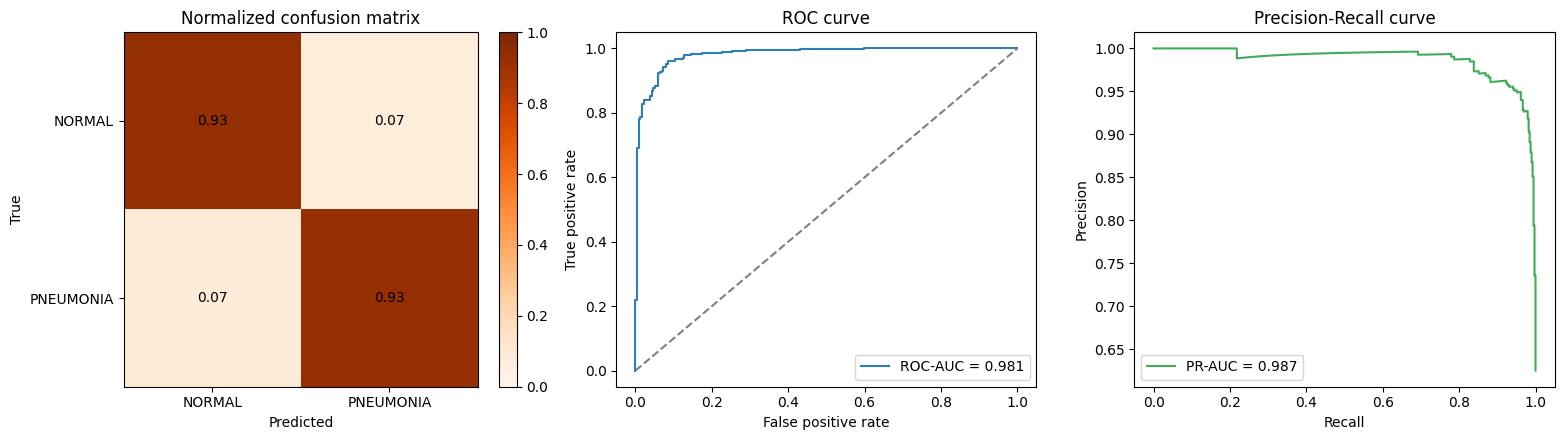

In [14]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
cm_norm = confusion_matrix(y_true, y_pred, normalize="true")

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

im = axes[0].imshow(cm_norm, cmap="Oranges", vmin=0, vmax=1)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        axes[0].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", color="black")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(class_names)
axes[0].set_yticklabels(class_names)
axes[0].set_title("Normalized confusion matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
fig.colorbar(im, ax=axes[0], fraction=0.046)

axes[1].plot(fpr, tpr, label=f"ROC-AUC = {auc_roc:.3f}", color="#2C7FB8")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[1].set_title("ROC curve")
axes[1].set_xlabel("False positive rate")
axes[1].set_ylabel("True positive rate")
axes[1].legend(loc="lower right")

axes[2].plot(recall_curve, precision_curve, label=f"PR-AUC = {auc_pr:.3f}", color="#41AB5D")
axes[2].set_title("Precision-Recall curve")
axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")
axes[2].legend(loc="lower left")

plt.tight_layout()
plt.show()

## Save model

In [17]:
torch.save(model.state_dict(), "./model.pth")